In [1]:
# Cell 0 — Setup (imports + auto-installer)

import sys, subprocess, importlib, os, math, random, json
from pathlib import Path
from typing import Tuple, List, Dict

import numpy as np
from PIL import Image

def ensure(pkg_pypi: str, import_name: str):
    """
    Try to import 'import_name'; if it fails, pip-install 'pkg_pypi' into this kernel.
    Return the imported module.
    """
    try:
        return importlib.import_module(import_name)
    except ModuleNotFoundError:
        print(f"Installing {pkg_pypi} into this kernel...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-U", pkg_pypi])
        return importlib.import_module(import_name)

# Colour science, YAML, Pandas, Matplotlib, TIFF writer
C = ensure("colour-science", "colour")
yaml = ensure("pyyaml", "yaml")
pd   = ensure("pandas", "pandas")
plt  = ensure("matplotlib", "matplotlib"); import matplotlib.pyplot as plt
tiff = ensure("tifffile", "tifffile")

# Colour utilities
from colour.notation.munsell import munsell_colour_to_xyY
from colour.difference import delta_E_CIE2000

print("colour-science:", C.__version__)


colour-science: 0.4.6


In [2]:
# Cell 1 — Load minimal config & derive constants

YAML_PATH = "/Users/kate/Documents/retina-model/configs/baseline.yaml"

with open(YAML_PATH, "r") as f:
    cfg = yaml.safe_load(f)

# --- Paths ---
IN_ROOT  = Path(cfg["mask_dir"])   # directory of binary PNG masks (object=black, bg=white)
OUT_ROOT = Path(cfg["out_dir"])
OUT_ROOT.mkdir(parents=True, exist_ok=True)

# --- Image size (H, W) ---
IMG_H, IMG_W = cfg.get("img_size", [64, 64])

# --- Splits / sampling ---
SEED   = int(cfg.get("seed", 1234))
SPLITS = dict(cfg["splits"])  # {'train':..., 'val':..., 'test':...}
TRIALS = SPLITS                # alias for compatibility

# --- Geometry ---
S_MIN, S_MAX     = map(int,   cfg["object_max_dim_px"])
ROT_MIN, ROT_MAX = map(float, cfg["rotation_deg"])
T_MIN, T_MAX     = map(int,   cfg["translation_px"])
BORDER           = int(cfg["border_px"])

# --- Colour (all D65-referred) ---
FIXED_BG_LAB   = np.array(cfg["background_lab"], float)  # dataset-wide gray (Lab, D65)
L0             = float(cfg["neutral_white_L"])           # L* for "tinted white" centre
TINT_RADII     = list(cfg["tint_radii"])                 # e.g., [5,10,15,20]
DE_MIN_PRE     = float(cfg.get("deltaE_min_obj_vs_bg", 0))

# --- Sampling / gamut policy ---
MAX_ATTEMPTS   = int(cfg.get("max_attempts", 100))
SHUFFLE_TINTS  = bool(cfg.get("shuffle_tints", True))
RS_OBJ_IF_TINT = bool(cfg.get("resample_object", True))
SKIP_IF_FAIL   = bool(cfg.get("skip_trial_if_fail", True))

# --- Output controls ---
MANIFEST_SUBDIR = cfg.get("manifest_dir", "manifests")
SAVE_PNG        = bool(cfg.get("save_png", True))
_scis = set(cfg.get("save_scientific_copies", []))
SAVE_TIFF_XYZ   = ("tiff_xyz" in _scis)
SAVE_NPZ        = ("npz" in _scis)
SAVE_MAT        = ("mat" in _scis)
SAVE_PER_TRIAL_JSON = True
SAVE_MANIFEST_CSV   = True

# --- Reproducibility ---
random.seed(SEED); np.random.seed(SEED)

print("Loaded config:", YAML_PATH)
print({
    "mask_dir": str(IN_ROOT),
    "out_dir": str(OUT_ROOT),
    "img_size": (IMG_H, IMG_W),
    "splits": SPLITS,
    "tint_radii": TINT_RADII,
    "shuffle_tints": SHUFFLE_TINTS,
    "max_attempts": MAX_ATTEMPTS,
    "outputs": {
        "png": SAVE_PNG, "tiff_xyz": SAVE_TIFF_XYZ, "npz": SAVE_NPZ, "mat": SAVE_MAT
    }
})


Loaded config: /Users/kate/Documents/retina-model/configs/baseline.yaml
{'mask_dir': '/Users/kate/Documents/retina-model/Image-set-1/original-bw-images/apples', 'out_dir': '/Users/kate/Documents/retina-model/image-set', 'img_size': (512, 512), 'splits': {'train': 128, 'val': 16, 'test': 16}, 'tint_radii': [5, 10, 15, 20], 'shuffle_tints': True, 'max_attempts': 100, 'outputs': {'png': True, 'tiff_xyz': True, 'npz': True, 'mat': True}}


In [3]:
# Cell 2 — Build/validate the Munsell pool we'll sample object colours from.
# (Start from the canonical 1600 chromatic grid and keep only codes the
#  'colour-science' library can convert. Typically ~1587 remain.)

HUE_FAMILIES = ['R','YR','Y','GY','G','BG','B','PB','P','RP']
HUE_STEPS    = [2.5, 5, 7.5, 10]
VALUES       = list(range(2, 10))     # 2..9
CHROMAS      = [2, 4, 6, 8, 10]       # chromatic (no /0 here)

def canonical_chromatics() -> List[str]:
    return [f"{hs}{fam} {V}/{Cc}"
            for fam in HUE_FAMILIES
            for hs in HUE_STEPS
            for V in VALUES
            for Cc in CHROMAS]

def is_valid_munsell(code: str) -> bool:
    try:
        xyY = munsell_colour_to_xyY(code)
        arr = np.asarray(xyY, float)
        return arr.shape == (3,) and np.all(np.isfinite(arr))
    except Exception:
        return False

codes_1600 = canonical_chromatics()
chips_full  = [c for c in codes_1600 if is_valid_munsell(c)]
print(f"Validated chromatic chips (full): {len(chips_full)}  (nominal 1600; typical ~1587)")


Validated chromatic chips (full): 1587  (nominal 1600; typical ~1587)


In [4]:
# Cell 3 — Colour math utilities and the 16-tint generator

# sRGB color space with D65 white (used throughout)
RGB_CS = C.RGB_COLOURSPACES["sRGB"]
ill_xy = np.array(RGB_CS.whitepoint, float)  # xy whitepoint for sRGB (D65)

# -- Basic conversions --
def XYZ_to_Lab(XYZ: np.ndarray) -> np.ndarray:
    return C.XYZ_to_Lab(np.asarray(XYZ, float), RGB_CS.whitepoint)

def Lab_to_XYZ(Lab: np.ndarray) -> np.ndarray:
    return C.Lab_to_XYZ(np.asarray(Lab, float), RGB_CS.whitepoint)

def XYZ_to_rgb_linear(XYZ: np.ndarray) -> np.ndarray:
    # Note: Colour 0.4.x signature → pass colourspace + whitepoint + CAT; no encoding
    return C.XYZ_to_RGB(np.asarray(XYZ, float), RGB_CS, ill_xy, "CAT02", apply_cctf_encoding=False)

def rgb_linear_to_XYZ(RGB_lin: np.ndarray) -> np.ndarray:
    return C.RGB_to_XYZ(np.asarray(RGB_lin, float), RGB_CS, ill_xy, "CAT02", apply_cctf_decoding=False)

def encode_sRGB(RGB_lin: np.ndarray) -> np.ndarray:
    # linear → display sRGB (gamma-encoded), still float [0..1]
    return RGB_CS.cctf_encoding(np.asarray(RGB_lin, float))

def deltaE00(Lab1, Lab2) -> float:
    return float(delta_E_CIE2000(np.asarray(Lab1, float), np.asarray(Lab2, float)))

def munsell_to_XYZ(code: str) -> np.ndarray:
    xyY = np.array(munsell_colour_to_xyY(code), dtype=float)
    return C.xyY_to_XYZ(xyY)

# -- Lighting model: uniform "chromatic light" via per-channel gains in linear sRGB --
NEUTRAL_LAB = np.array([L0, 0.0, 0.0], float)  # tinted white center (L*, a*, b*) for neutral

def lighting_multiplier_linear_sRGB(tint_Lab: np.ndarray, neutral_Lab: np.ndarray) -> np.ndarray:
    """
    Compute per-channel multipliers k so that the neutral white (Lab=L0,0,0)
    maps to the tinted white (Lab=tint_Lab) in linear sRGB:
      k = RGB_lin(tinted_white) / RGB_lin(neutral_white)
    """
    RGBw_neutral = XYZ_to_rgb_linear(Lab_to_XYZ(neutral_Lab))
    RGBw_tint    = XYZ_to_rgb_linear(Lab_to_XYZ(tint_Lab))
    eps = 1e-8
    return (RGBw_tint + eps) / (RGBw_neutral + eps)

def apply_uniform_lighting_linear_sRGB(XYZ_img: np.ndarray, tint_Lab: np.ndarray, neutral_Lab: np.ndarray) -> np.ndarray:
    """
    Apply uniform "lighting" to an XYZ image in linear sRGB and return linear sRGB.
    """
    RGB_lin = XYZ_to_rgb_linear(XYZ_img)
    k = lighting_multiplier_linear_sRGB(tint_Lab, neutral_Lab)
    return RGB_lin * k

# -- Build chromatic tints: ±a*, ±b* at requested radii with L* fixed at L0 --
def build_lab_tints(L0: float, radii: List[int]) -> List[np.ndarray]:
    tints = []
    for r in radii:
        tints += [(L0, +r, 0.0), (L0, -r, 0.0), (L0, 0.0, +r), (L0, 0.0, -r)]
    return [np.array(t, float) for t in tints]

# -- Dataset-wide background (pre-tint) in XYZ and linear RGB (under D65) --
XYZ_BG_GRAY_D65  = Lab_to_XYZ(FIXED_BG_LAB)
RGB_BG_GRAY_LIN  = XYZ_to_rgb_linear(XYZ_BG_GRAY_D65)

# -- Gamut tests --
def in_gamut_lin(rgb_lin: np.ndarray) -> bool:
    """True if ALL components in rgb_lin are within [0, 1]."""
    m = float(np.min(rgb_lin)); M = float(np.max(rgb_lin))
    return (m >= 0.0) and (M <= 1.0)

def will_initial_clip(RGB_obj_lin_D65: np.ndarray, k: np.ndarray) -> bool:
    """
    Given object (under D65) linear RGB and lighting multiplier k,
    return True if either the object-after-tint OR the background-after-tint clips.
    """
    obj_lit = RGB_obj_lin_D65 * k
    bg_lit  = RGB_BG_GRAY_LIN * k
    return (not in_gamut_lin(obj_lit)) or (not in_gamut_lin(bg_lit))

def will_candidates_clip(RGB_obj_lin_D65: np.ndarray, Lab_obj_post_init: np.ndarray) -> bool:
    """
    For candidates under D65:
      - A uses object pre (under D65) → check its linear RGB.
      - B uses object post-init as pre under D65 → convert Lab to linear RGB and check.
      - Background is the dataset gray under D65 → check once (static).
    """
    if not in_gamut_lin(RGB_obj_lin_D65):
        return True
    if not in_gamut_lin(RGB_BG_GRAY_LIN):
        return True
    # B object (appearance-match under D65)
    RGB_B_lin = XYZ_to_rgb_linear(Lab_to_XYZ(Lab_obj_post_init))
    if not in_gamut_lin(RGB_B_lin):
        return True
    return False


In [5]:
# Cell 4 — Turn your binary PNGs into boolean masks and apply one geometry transform
# (scale, rotate, translate) shared by all 3 images in a trial.

def load_binary_mask(path: Path, thresh: int = 128) -> np.ndarray:
    """
    Load an RGB PNG where the object is black and the background is white.
    Return a boolean mask: True for object pixels.
    """
    arr = np.asarray(Image.open(path).convert("RGB"), dtype=np.uint8)
    gray = arr.mean(axis=2)
    return (gray < thresh)

def bbox_from_mask(M: np.ndarray):
    ys, xs = np.where(M)
    if xs.size == 0: return None
    return xs.min(), ys.min(), xs.max(), ys.max()

def center_paste(canvas_hw: Tuple[int,int], patch: np.ndarray) -> np.ndarray:
    H,W = canvas_hw
    ph,pw = patch.shape
    out = np.zeros((H,W), dtype=bool)
    y0 = (H - ph)//2
    x0 = (W - pw)//2
    out[y0:y0+ph, x0:x0+pw] = patch
    return out

def scale_mask_to_maxdim(M: np.ndarray, target_max: int) -> np.ndarray:
    bb = bbox_from_mask(M); assert bb is not None, "Empty mask!"
    x0,y0,x1,y1 = bb
    obj = M[y0:y1+1, x0:x1+1]
    h,w = obj.shape
    scale = target_max / max(h,w)
    new_h = max(1, int(round(h*scale)))
    new_w = max(1, int(round(w*scale)))
    obj_res = Image.fromarray((obj.astype(np.uint8) * 255)).resize((new_w, new_h), Image.NEAREST)
    obj_res = (np.asarray(obj_res, np.uint8) > 0)
    return center_paste((IMG_H, IMG_W), obj_res)

def rotate_mask_keep(M: np.ndarray, deg: float) -> np.ndarray:
    img = Image.fromarray((M.astype(np.uint8) * 255))
    big = img.rotate(deg, resample=Image.NEAREST, expand=True, fillcolor=0)
    big_np = (np.asarray(big, np.uint8) > 0)
    H,W = big_np.shape
    y0 = max(0, (H-IMG_H)//2); x0 = max(0, (W-IMG_W)//2)
    crop = big_np[y0:y0+IMG_H, x0:x0+IMG_W]
    out = np.zeros((IMG_H, IMG_W), bool)
    out[:crop.shape[0], :crop.shape[1]] = crop
    return out

def translate_mask(M: np.ndarray, dx: int, dy: int) -> np.ndarray:
    out = np.zeros_like(M)
    H,W = M.shape
    x0 = max(0, dx); y0 = max(0, dy)
    x1 = min(W, W+dx); y1 = min(H, H+dy)
    sx0 = max(0, -dx); sy0 = max(0, -dy)
    sx1 = sx0 + (x1 - x0); sy1 = sy0 + (y1 - y0)
    out[y0:y1, x0:x1] = M[sy0:sy1, sx0:sx1]
    return out

def min_margin(M: np.ndarray) -> int:
    ys, xs = np.where(M)
    if xs.size == 0: return 0
    return int(min(xs.min(), IMG_W - 1 - xs.max(), ys.min(), IMG_H - 1 - ys.max()))

def sample_angle_and_translate(M_scaled: np.ndarray) -> Tuple[float, int, int, np.ndarray]:
    """
    Randomly rotate then translate until the object stays ≥ BORDER px from edges.
    Up to 200 tries; if it fails, consider relaxing YAML geometry ranges.
    """
    for _ in range(200):
        ang = random.uniform(ROT_MIN, ROT_MAX)
        Mr = rotate_mask_keep(M_scaled, ang)
        if min_margin(Mr) >= BORDER:
            r = random.randint(T_MIN, T_MAX)
            theta = random.uniform(0, 2*math.pi)
            dx = int(round(r * math.cos(theta)))
            dy = int(round(r * math.sin(theta)))
            Mt = translate_mask(Mr, dx, dy)
            if min_margin(Mt) >= BORDER:
                return ang, dx, dy, Mt
    raise RuntimeError("Could not satisfy border constraints with current geometry settings.")

In [6]:
# Cell 5 — Colour selection & resampling (no exposure scaling; resample until all-in-gamut)

def build_XYZ_from_mask(M: np.ndarray, XYZ_obj: np.ndarray, XYZ_bg: np.ndarray) -> np.ndarray:
    """
    Construct an XYZ image with two solid colours:
      - object pixels: XYZ_obj
      - background pixels: XYZ_bg
    """
    H, W = M.shape
    out = np.empty((H, W, 3), float)
    out[M]  = XYZ_obj
    out[~M] = XYZ_bg
    return out

def rgb_lin_to_u8(RGB_lin: np.ndarray) -> np.ndarray:
    """Encode linear sRGB to display sRGB and quantize to uint8 (0..255)."""
    RGB_disp = np.clip(encode_sRGB(np.clip(RGB_lin, 0.0, 1.0)), 0.0, 1.0)
    return (RGB_disp * 255.0 + 0.5).astype(np.uint8)

def choose_tint_order() -> List[np.ndarray]:
    """
    Return a list of all tints (±a*, ±b* × radii).
    Shuffle if SHUFFLE_TINTS=True.
    """
    tints = build_lab_tints(L0, TINT_RADII)
    if SHUFFLE_TINTS:
        random.shuffle(tints)
    return tints

def pick_object_and_tint_with_resampling() -> Dict:
    """
    Find (object chip, tint) so that:
      - INITIAL (object + BG) AFTER tint is in-gamut (linear sRGB ∈ [0,1], no scaling).
      - CANDIDATES (under D65) are in-gamut (A uses object-pre; B uses object-post-init as pre).
      - Optional: ΔE00(obj_pre, bg_pre) >= DE_MIN_PRE (under D65).
    Strategy:
      - Draw an object from the validated Munsell pool.
      - Try tints in choose_tint_order().
      - If all tints fail, draw a new object (if allowed) and retry.
      - Cap attempts at MAX_ATTEMPTS; optionally skip trial if exhausted.
    Returns:
      dict with 'ok' flag, selected codes/colours, the lighting multiplier k, Lab post for object,
      counters (attempts_total/tint/object), and background Lab/XYZ.
    """
    attempts_total = 0
    attempts_tint  = 0
    attempts_obj   = 0

    # Background under D65 (fixed for the dataset)
    Lab_bg_pre = FIXED_BG_LAB
    XYZ_bg_pre = XYZ_BG_GRAY_D65
    RGB_bg_lin = RGB_BG_GRAY_LIN

    # Must be in-gamut by design
    assert in_gamut_lin(RGB_bg_lin), "Fixed background gray (D65) is out of sRGB gamut; adjust YAML."

    while attempts_total < MAX_ATTEMPTS:
        attempts_total += 1
        attempts_obj   += 1

        # 1) Draw an object chip from the validated pool
        obj_code = random.choice(chips_full)
        XYZ_obj_pre = munsell_to_XYZ(obj_code)      # D65-referred
        Lab_obj_pre = XYZ_to_Lab(XYZ_obj_pre)

        # Optional pre separation from BG under D65
        if DE_MIN_PRE > 0 and deltaE00(Lab_obj_pre, Lab_bg_pre) < DE_MIN_PRE:
            continue

        # Early reject if object under D65 is already out-of-gamut for candidates (A)
        RGB_obj_lin_D65 = XYZ_to_rgb_linear(XYZ_obj_pre)
        if not in_gamut_lin(RGB_obj_lin_D65):
            continue

        # 2) Try tints in the requested order
        for tint_Lab in choose_tint_order():
            attempts_tint += 1

            # Lighting multipliers for linear sRGB (uniform lighting)
            k = lighting_multiplier_linear_sRGB(tint_Lab, NEUTRAL_LAB)

            # INITIAL: tint applies to object & background → both must stay in gamut
            if will_initial_clip(RGB_obj_lin_D65, k):
                continue

            # Compute object post-tint Lab (for appearance-match), from linear RGB after lighting
            Lab_obj_post_init = XYZ_to_Lab(rgb_linear_to_XYZ(RGB_obj_lin_D65 * k))

            # CANDIDATES under D65 must be in-gamut (A uses obj_pre; B uses obj_post_init)
            if will_candidates_clip(RGB_obj_lin_D65, Lab_obj_post_init):
                continue

            # Success: this (object, tint) is valid with no scaling
            return dict(
                ok=True,
                # object (pre-tint, under D65)
                obj_code=obj_code,
                XYZ_obj_pre=XYZ_obj_pre,
                Lab_obj_pre=Lab_obj_pre,
                RGB_obj_lin_D65=RGB_obj_lin_D65,
                # background (pre-tint, under D65)
                XYZ_bg_pre=XYZ_bg_pre,
                Lab_bg_pre=Lab_bg_pre,
                # lighting
                tint_Lab=tint_Lab,
                k=k,
                # object post-tint (for initial, and for candB under D65)
                Lab_obj_post_init=Lab_obj_post_init,
                # counters
                attempts_total=attempts_total,
                attempts_tint=attempts_tint,
                attempts_obj=attempts_obj,
                # (optional) diagnostic
                dE_obj_vs_bg_pre=deltaE00(Lab_obj_pre, Lab_bg_pre),
            )

        # If no tint worked for this object, optionally draw a new object
        if not RS_OBJ_IF_TINT:
            break  # give up—resampling object is disabled

    # Exhausted attempts
    if SKIP_IF_FAIL:
        return dict(ok=False, skipped=True, reason="resample_exhausted",
                    attempts_total=attempts_total, attempts_tint=attempts_tint, attempts_obj=attempts_obj)
    raise RuntimeError("Could not find a valid (object, tint) within the resample limits.")

In [7]:
# Cell 6 — Build ONE trial; save PNG/TIFF/NPZ/MAT; write manifest row (robust bindings)

# ---- Safety defaults from YAML (in case of partial execution) ----
SAVE_PNG            = globals().get("SAVE_PNG", True)
SAVE_TIFF_XYZ       = globals().get("SAVE_TIFF_XYZ", False)
SAVE_NPZ            = globals().get("SAVE_NPZ", False)
SAVE_MAT            = globals().get("SAVE_MAT", False)
SAVE_PER_TRIAL_JSON = globals().get("SAVE_PER_TRIAL_JSON", True)

def ensure_dir(p: Path): p.mkdir(parents=True, exist_ok=True)

def save_png(arr_u8: np.ndarray, path: Path):
    Image.fromarray(arr_u8).save(path, "PNG")

def save_xyz_tiff(path: Path, XYZ: np.ndarray):
    """Save float32 XYZ as a 3-channel TIFF (D65-referred)."""
    assert XYZ.dtype == np.float32 and XYZ.ndim == 3 and XYZ.shape[2] == 3
    tiff.imwrite(str(path), XYZ, dtype=np.float32)

def save_lab_xyz_npz(path: Path, **arrays_and_meta):
    """Save Lab/XYZ arrays (float32) plus small metadata as a compressed NPZ."""
    np.savez_compressed(path, **arrays_and_meta)

def save_lab_xyz_mat(path: Path, **arrays_and_meta):
    """
    Save a MATLAB .mat sidecar. Tries to import SciPy; installs if missing.
    Keys should be flat (MATLAB structs are limited).
    """
    try:
        from scipy import io as spio
    except Exception:
        import sys as _sys, subprocess as _subp
        _subp.check_call([_sys.executable, "-m", "pip", "install", "-U", "scipy"])
        from scipy import io as spio

    cleaned = {}
    for k, v in arrays_and_meta.items():
        if isinstance(v, (np.floating, np.integer)):
            cleaned[k] = v.item()
        else:
            cleaned[k] = v
    spio.savemat(str(path), cleaned, do_compression=True)

# ---- Preflight: ensure helpers exist BEFORE binding them into one_trial ----
_needed = [
    "load_binary_mask", "scale_mask_to_maxdim", "sample_angle_and_translate",
    "build_XYZ_from_mask", "apply_uniform_lighting_linear_sRGB", "in_gamut_lin",
    "XYZ_to_rgb_linear", "rgb_linear_to_XYZ", "encode_sRGB", "Lab_to_XYZ", "XYZ_to_Lab",
    "RGB_BG_GRAY_LIN", "NEUTRAL_LAB", "pick_object_and_tint_with_resampling",
    "IMG_H", "IMG_W", "S_MIN", "S_MAX", "BORDER",
    "L0", "FIXED_BG_LAB", "OUT_ROOT"
]
_missing = [n for n in _needed if n not in globals()]
if _missing:
    raise RuntimeError(
        "Missing required definitions from earlier cells: "
        + ", ".join(_missing)
        + ".\nPlease run Cells 2–5 (helpers) and Cell 1 (constants) before this cell."
    )

def one_trial(
    mask_paths: List[Path], split: str, trial_id: int, out_split_dir: Path,
    # --- bind helpers/consts at definition-time to avoid late-binding NameErrors ---
    _load_binary_mask=load_binary_mask,
    _scale_mask_to_maxdim=scale_mask_to_maxdim,
    _sample_angle_and_translate=sample_angle_and_translate,
    _build_XYZ_from_mask=build_XYZ_from_mask,
    _apply_uniform_lighting_linear_sRGB=apply_uniform_lighting_linear_sRGB,
    _in_gamut_lin=in_gamut_lin,
    _XYZ_to_rgb_linear=XYZ_to_rgb_linear,
    _rgb_linear_to_XYZ=rgb_linear_to_XYZ,
    _encode_sRGB=encode_sRGB,
    _Lab_to_XYZ=Lab_to_XYZ,
    _XYZ_to_Lab=XYZ_to_Lab,
    _RGB_BG_GRAY_LIN=RGB_BG_GRAY_LIN,
    _NEUTRAL_LAB=NEUTRAL_LAB,
    _pick_object_and_tint_with_resampling=pick_object_and_tint_with_resampling,
    _IMG_H=IMG_H, _IMG_W=IMG_W,
    _S_MIN=S_MIN, _S_MAX=S_MAX, _BORDER=BORDER,
    _L0=L0, _FIXED_BG_LAB=FIXED_BG_LAB,
    _OUT_ROOT=OUT_ROOT
) -> Dict:
    # --- Geometry shared across the triplet ---
    mask_path = random.choice(mask_paths)
    M0 = _load_binary_mask(mask_path)
    target_max = random.randint(_S_MIN, _S_MAX)
    M_scaled = _scale_mask_to_maxdim(M0, target_max)
    ang, dx, dy, M_geom = _sample_angle_and_translate(M_scaled)

    # --- Colour choices (with resampling for gamut) ---
    choice = _pick_object_and_tint_with_resampling()
    if not choice.get("ok", False):
        # If we skip, return a minimal row (will be filtered out later)
        return {**choice, "split": split, "trial_id": trial_id, "skipped": 1}

    # Unpack choices
    obj_code          = choice["obj_code"]
    Lab_obj_pre       = choice["Lab_obj_pre"]
    XYZ_obj_pre       = choice["XYZ_obj_pre"]
    RGB_obj_lin_D65   = choice["RGB_obj_lin_D65"]
    tint_Lab          = choice["tint_Lab"]
    k                 = choice["k"]
    Lab_bg_pre        = choice["Lab_bg_pre"]
    XYZ_bg_pre        = choice["XYZ_bg_pre"]
    Lab_obj_post_init = choice["Lab_obj_post_init"]

    # --- INITIAL (tint applies to whole image) ---
    XYZ_init_pre = _build_XYZ_from_mask(M_geom, XYZ_obj_pre, XYZ_bg_pre)
    RGB_init_lin = _apply_uniform_lighting_linear_sRGB(XYZ_init_pre, tint_Lab, _NEUTRAL_LAB).astype(np.float32)
    assert _in_gamut_lin(RGB_init_lin), "Initial image went out of gamut unexpectedly (after resampling)."

    XYZ_init_post = _rgb_linear_to_XYZ(RGB_init_lin).astype(np.float32)
    Lab_init_post = _XYZ_to_Lab(XYZ_init_post).astype(np.float32)

    # Swatch-level "post" for initial
    RGB_bg_post_lin = _RGB_BG_GRAY_LIN * k
    Lab_bg_post     = _XYZ_to_Lab(_rgb_linear_to_XYZ(RGB_bg_post_lin)).astype(np.float32)
    Lab_obj_post    = Lab_obj_post_init.astype(np.float32)

    # --- CANDIDATE A (same surface under D65 on fixed gray) ---
    XYZ_candA = _build_XYZ_from_mask(M_geom, XYZ_obj_pre, XYZ_bg_pre).astype(np.float32)
    RGB_A_lin = _XYZ_to_rgb_linear(XYZ_candA).astype(np.float32)
    assert _in_gamut_lin(RGB_A_lin), "Candidate A out of gamut unexpectedly."

    # --- CANDIDATE B (appearance match under D65 on fixed gray) ---
    XYZ_candB_obj = _Lab_to_XYZ(Lab_obj_post)
    XYZ_candB = _build_XYZ_from_mask(M_geom, XYZ_candB_obj, XYZ_bg_pre).astype(np.float32)
    RGB_B_lin = _XYZ_to_rgb_linear(XYZ_candB).astype(np.float32)
    assert _in_gamut_lin(RGB_B_lin), "Candidate B out of gamut unexpectedly."

    # --- Encode all three as PNG (if requested; no exposure scaling) ---
    to_u8 = lambda RGB_lin: (_encode_sRGB(np.clip(RGB_lin, 0, 1)) * 255 + 0.5).astype(np.uint8)
    init_u8, candA_u8, candB_u8 = to_u8(RGB_init_lin), to_u8(RGB_A_lin), to_u8(RGB_B_lin)

    # --- Randomize candidate order; label=1 if FIRST is SAME-SURFACE (A) ---
    order = random.choice(["A_first", "B_first"])
    correct_label = 1 if order == "A_first" else 0

    # --- Save outputs ---
    tdir = out_split_dir / f"trial_{trial_id:06d}"
    ensure_dir(tdir)

    # PNGs (controlled by YAML) + set XYZ_cand1/2 for scientific outputs
    initial_path = cand1_path = cand2_path = ""
    if SAVE_PNG:
        save_png(init_u8, tdir / "initial.png")
        if order == "A_first":
            save_png(candA_u8, tdir / "cand1.png")
            save_png(candB_u8, tdir / "cand2.png")
            XYZ_cand1, XYZ_cand2 = XYZ_candA, XYZ_candB
        else:
            save_png(candB_u8, tdir / "cand1.png")
            save_png(candA_u8, tdir / "cand2.png")
            XYZ_cand1, XYZ_cand2 = XYZ_candB, XYZ_candA

        initial_path = str((tdir / "initial.png").relative_to(_OUT_ROOT))
        cand1_path   = str((tdir / "cand1.png").relative_to(_OUT_ROOT))
        cand2_path   = str((tdir / "cand2.png").relative_to(_OUT_ROOT))
    else:
        if order == "A_first":
            XYZ_cand1, XYZ_cand2 = XYZ_candA, XYZ_candB
        else:
            XYZ_cand1, XYZ_cand2 = XYZ_candB, XYZ_candA

    # Scientific copies
    if SAVE_TIFF_XYZ:
        save_xyz_tiff(tdir / "initial_XYZ.tiff", XYZ_init_post)
        save_xyz_tiff(tdir / "cand1_XYZ.tiff",   XYZ_cand1)
        save_xyz_tiff(tdir / "cand2_XYZ.tiff",   XYZ_cand2)

    if SAVE_NPZ:
        Lab_candA = _XYZ_to_Lab(XYZ_candA).astype(np.float32)
        Lab_candB = _XYZ_to_Lab(XYZ_candB).astype(np.float32)
        save_lab_xyz_npz(
            tdir / "colours.npz",
            XYZ_init=XYZ_init_post.astype(np.float32),
            XYZ_candA=XYZ_candA.astype(np.float32),
            XYZ_candB=XYZ_candB.astype(np.float32),
            Lab_init=Lab_init_post.astype(np.float32),
            Lab_candA=Lab_candA,
            Lab_candB=Lab_candB,
            meta_whitepoint="D65",
            meta_neutral_white_L=float(_L0),
            meta_background_lab_pre=_FIXED_BG_LAB.astype(np.float32),
            meta_tint_lab=tint_Lab.astype(np.float32),
            meta_appearance_match_mode="direct",
        )

    if SAVE_MAT:
        Lab_candA = _XYZ_to_Lab(XYZ_candA).astype(np.float32)
        Lab_candB = _XYZ_to_Lab(XYZ_candB).astype(np.float32)
        save_lab_xyz_mat(
            tdir / "colours.mat",
            XYZ_init=XYZ_init_post.astype(np.float32),
            XYZ_candA=XYZ_candA.astype(np.float32),
            XYZ_candB=XYZ_candB.astype(np.float32),
            Lab_init=Lab_init_post.astype(np.float32),
            Lab_candA=Lab_candA,
            Lab_candB=Lab_candB,
            meta_whitepoint="D65",
            meta_neutral_white_L=float(_L0),
            meta_background_lab_pre=_FIXED_BG_LAB.astype(np.float32),
            meta_tint_lab=tint_Lab.astype(np.float32),
            meta_appearance_match_mode="direct",
        )

    # --- Manifest row ---
    def json_vec(v):
        v = np.asarray(v).astype(float).tolist()
        return json.dumps([round(x, 5) for x in v])

    def pix_rgb_u8_from_lab(Lab):
        rgb_lin = _XYZ_to_rgb_linear(_Lab_to_XYZ(Lab))
        return (_encode_sRGB(np.clip(rgb_lin, 0, 1)) * 255 + 0.5).astype(np.uint8)

    # sRGB swatches (for viewer/checks)
    obj_pre_rgb   = pix_rgb_u8_from_lab(Lab_obj_pre)
    bg_pre_rgb    = pix_rgb_u8_from_lab(Lab_bg_pre)
    tint_rgb      = pix_rgb_u8_from_lab(tint_Lab)
    obj_post_rgb  = pix_rgb_u8_from_lab(Lab_obj_post)
    bg_post_rgb   = pix_rgb_u8_from_lab(Lab_bg_post)

    row = {
        "split": split, "trial_id": trial_id, "skipped": 0,
        "mask_file": mask_path.name,
        "image_size": f"{_IMG_H}x{_IMG_W}",
        "target_max_dim": target_max,
        "rotation_deg": float(ang), "dx": dx, "dy": dy,
        "obj_munsell": obj_code,
        "order": order,
        "correct_label": correct_label,
        "resample_attempts_total": choice["attempts_total"],
        "resample_attempts_tint":  choice["attempts_tint"],
        "resample_attempts_object": choice["attempts_obj"],
        "initial_path": initial_path,
        "cand1_path":   cand1_path,
        "cand2_path":   cand2_path,
        # Lab fields for analysis/viewer
        "tint_lab":          json_vec(tint_Lab),
        "bg_lab_pre":        json_vec(Lab_bg_pre),
        "obj_lab_pre":       json_vec(Lab_obj_pre),
        "obj_lab_post_init": json_vec(Lab_obj_post),
        "bg_lab_post_init":  json_vec(Lab_bg_post),
        # sRGB bytes for viewer/sanity checks
        "obj_rgb_pre":          json.dumps(obj_pre_rgb.tolist()),
        "bg_rgb_pre":           json.dumps(bg_pre_rgb.tolist()),
        "tint_rgb":             json.dumps(tint_rgb.tolist()),
        "obj_rgb_post_init":    json.dumps(obj_post_rgb.tolist()),
        "bg_rgb_post_init":     json.dumps(bg_post_rgb.tolist()),
        "candA_obj_rgb":        json.dumps(obj_pre_rgb.tolist()),
        "candB_obj_rgb":        json.dumps(obj_post_rgb.tolist()),
        "cand_bg_rgb":          json.dumps(bg_pre_rgb.tolist()),
    }

    if SAVE_PER_TRIAL_JSON:
        with open(tdir / "trial.json", "w") as f:
            json.dump({**row, "geometry": {"S_max": target_max, "angle": float(ang), "dx": dx, "dy": dy}}, f, indent=2)

    return row


In [8]:
# Cell 7 — Generate dataset across splits; write manifest; print resampling stats.

if "one_trial" not in globals():
    raise RuntimeError("Cell 6 (one_trial) has not been executed in this kernel. Please run Cell 6, then re-run this cell.")

mask_paths = sorted(IN_ROOT.glob("*.png"))
assert mask_paths, f"No PNGs found in {IN_ROOT}"

rows = []
skipped = 0

for split in ["train", "val", "test"]:
    n = int(TRIALS[split])
    out_split_dir = OUT_ROOT / split
    out_split_dir.mkdir(parents=True, exist_ok=True)

    i = 1
    while i <= n:
        row = one_trial(mask_paths, split, i, out_split_dir)
        # If a trial was skipped, try again (same trial_id)
        if row.get("skipped", 0) == 1:
            skipped += 1
            continue
        rows.append(row)
        i += 1

# Write manifest CSV
manifest_dir = OUT_ROOT / MANIFEST_SUBDIR
manifest_dir.mkdir(parents=True, exist_ok=True)
csv_path = manifest_dir / "trials.csv"
CSV_PATH = csv_path  # keep for later cells

if SAVE_MANIFEST_CSV and rows:
    df = pd.DataFrame(rows)
    df.to_csv(csv_path, index=False)

print(f"Done. Wrote {len(rows)} trials: train={TRIALS['train']}, val={TRIALS['val']}, test={TRIALS['test']}")
print(f"Manifest: {csv_path}")
print(f"Skipped due to gamut: {skipped}")

# Quick summary of resampling effort
if rows:
    df = pd.DataFrame(rows)
    print("Resample attempts per kept trial (mean ± sd):",
          f"{df['resample_attempts_total'].mean():.2f} ± {df['resample_attempts_total'].std():.2f}")
    print("99th percentile:", np.percentile(df['resample_attempts_total'], 99))


Done. Wrote 160 trials: train=128, val=16, test=16
Manifest: /Users/kate/Documents/retina-model/image-set/manifests/trials.csv
Skipped due to gamut: 0
Resample attempts per kept trial (mean ± sd): 1.27 ± 0.63
99th percentile: 4.0


In [9]:
# Cell 8 — GUI viewer: 3 large images + two small bar charts

from IPython.display import clear_output

def parse_vec_json(s):
    try:
        return np.array(json.loads(s), float)
    except Exception:
        return np.array([np.nan, np.nan, np.nan], float)

def vec_u8_to_np(s):
    try:
        return np.array(json.loads(s), int)
    except Exception:
        return np.array([np.nan, np.nan, np.nan], int)

def show_trial(split="train", tid=1):
    # Load row from manifest
    man_csv = OUT_ROOT / MANIFEST_SUBDIR / "trials.csv"
    df = pd.read_csv(man_csv)
    row = df[(df["split"]==split) & (df["trial_id"]==tid)]
    assert not row.empty, f"No manifest row for {split}/trial {tid}"
    r = row.iloc[0]

    tdir = OUT_ROOT / split / f"trial_{tid:06d}"
    # Load images as arrays (keeps them crisp at 64×64)
    init_img  = np.asarray(Image.open(tdir/"initial.png"))
    cand1_img = np.asarray(Image.open(tdir/"cand1.png"))
    cand2_img = np.asarray(Image.open(tdir/"cand2.png"))

    # ---- Use a single, consistent set of names for both Lab and sRGB ----
    names = [
        "Obj pre",
        "BG pre (D65)",
        "Tint",
        "Obj post (init)",
        "BG post (init)",
        "CandA obj (D65)",
        "CandB obj (D65)",
        "Cand BG (D65)",
    ]

    # Lab triplets
    labs = {
        "Obj pre":            parse_vec_json(r["obj_lab_pre"]),
        "BG pre (D65)":       parse_vec_json(r["bg_lab_pre"]),
        "Tint":               parse_vec_json(r["tint_lab"]),
        "Obj post (init)":    parse_vec_json(r["obj_lab_post_init"]),
        "BG post (init)":     parse_vec_json(r["bg_lab_post_init"]),
        "CandA obj (D65)":    parse_vec_json(r["obj_lab_pre"]),
        "CandB obj (D65)":    parse_vec_json(r["obj_lab_post_init"]),
        "Cand BG (D65)":      parse_vec_json(r["bg_lab_pre"]),    # same as BG pre by design
    }

    # sRGB (as saved) — 0..255
    rgbs = {
        "Obj pre":            vec_u8_to_np(r["obj_rgb_pre"]),
        "BG pre (D65)":       vec_u8_to_np(r["bg_rgb_pre"]),
        "Tint":               vec_u8_to_np(r["tint_rgb"]),
        "Obj post (init)":    vec_u8_to_np(r["obj_rgb_post_init"]),
        "BG post (init)":     vec_u8_to_np(r["bg_rgb_post_init"]),
        "CandA obj (D65)":    vec_u8_to_np(r["candA_obj_rgb"]),
        "CandB obj (D65)":    vec_u8_to_np(r["candB_obj_rgb"]),
        "Cand BG (D65)":      vec_u8_to_np(r["cand_bg_rgb"]),
    }

    # Optional sanity check: candidate BG should equal BG pre (byte-identical)
    cand_bg_matches = np.array_equal(rgbs["Cand BG (D65)"], rgbs["BG pre (D65)"])

    # ---- Build figure: 2 rows, 6 columns (top images big, bottom charts small) ----
    fig = plt.figure(figsize=(14, 8))  # overall size
    gs = fig.add_gridspec(nrows=2, ncols=6, height_ratios=[4, 1], wspace=0.05, hspace=0.35)

    # Top row: three large image axes (each spans 2 columns)
    ax_i  = fig.add_subplot(gs[0, 0:2])
    ax_c1 = fig.add_subplot(gs[0, 2:4])
    ax_c2 = fig.add_subplot(gs[0, 4:6])

    ax_i.imshow(init_img, interpolation='nearest');   ax_i.set_title("Initial", fontsize=12)
    ax_c1.imshow(cand1_img, interpolation='nearest'); ax_c1.set_title("Candidate 1", fontsize=12)
    ax_c2.imshow(cand2_img, interpolation='nearest'); ax_c2.set_title("Candidate 2", fontsize=12)
    for ax in (ax_i, ax_c1, ax_c2):
        ax.axis('off')

    # Bottom row: two small bar charts, side-by-side
    ax_lab = fig.add_subplot(gs[1, 0:3])   # left half for Lab
    ax_rgb = fig.add_subplot(gs[1, 3:6])   # right half for sRGB

    # ---- Lab bar plot (small) ----
    Ls  = [labs[k][0] for k in names]
    a_s = [labs[k][1] for k in names]
    b_s = [labs[k][2] for k in names]
    x = np.arange(len(names))
    w = 0.25

    ax_lab.bar(x - w, Ls,  width=w, label='L*')
    ax_lab.bar(x,     a_s, width=w, label='a*')
    ax_lab.bar(x + w, b_s, width=w, label='b*')
    ax_lab.set_xticks(x, names, rotation=30, ha='right')
    ax_lab.set_title("CIELAB (small summary)", fontsize=10)
    ax_lab.grid(True, axis='y', alpha=0.3)
    ax_lab.legend(fontsize=8)
    ax_lab.tick_params(axis='both', labelsize=8)

    # ---- sRGB bar plot (small) ----
    Rs = [rgbs[k][0] for k in names]
    Gs = [rgbs[k][1] for k in names]
    Bs = [rgbs[k][2] for k in names]

    ax_rgb.bar(x - w, Rs, width=w, label='R (0..255)')
    ax_rgb.bar(x,     Gs, width=w, label='G (0..255)')
    ax_rgb.bar(x + w, Bs, width=w, label='B (0..255)')
    ax_rgb.set_xticks(x, names, rotation=30, ha='right')
    title = "sRGB (as saved)"
    if not cand_bg_matches:
        title += "  —  ⚠ BG mismatch!"
    ax_rgb.set_title(title, fontsize=10)
    ax_rgb.grid(True, axis='y', alpha=0.3)
    ax_rgb.legend(fontsize=8)
    ax_rgb.tick_params(axis='both', labelsize=8)

    # Overall title line with split/trial info
    fig.suptitle(f"{split} / trial {tid}   |   order={r['order']}   |   correct_label={r['correct_label']}",
                 fontsize=12, y=0.98)
    plt.show()

def browse_trials(split="train", start=1):
    tid = int(start)
    n = int(TRIALS[split])
    while True:
        clear_output(wait=True)
        show_trial(split, tid)
        cmd = input("Enter=next | p=prev | r=random | train|val|test | q=quit: ").strip().lower()
        if cmd in ("q", "quit", "x"):
            break
        elif cmd in ("p", "prev"):
            tid = max(1, tid - 1)
        elif cmd in ("r", "rand", "random"):
            tid = random.randint(1, n)
        elif cmd in ("train", "val", "test"):
            split = cmd
            n = int(TRIALS[split])
            tid = 1
        else:
            tid = min(n, tid + 1)

# Start viewer at first training trial
# browse_trials("train", 1)


In [10]:
# Cell 9 — Quick CSV checks

CSV_PATH  # ensure it exists from Cell 7

df = pd.read_csv(CSV_PATH)
print("First-try success rate:", (df["resample_attempts_total"]==1).mean())
print("By split:")
print(df.groupby("split")["resample_attempts_total"].agg(["mean","std","median","max","count"]))

# Candidate BG bytes should be identical dataset-wide (D65, no scaling).
bg_vals = df["cand_bg_rgb"].unique()
print("Unique candidate BG codes (should be 1):", len(bg_vals), bg_vals[:3])

def parse_lab(s): return np.array(json.loads(s), float)
df["tint_lab_vec"] = df["tint_lab"].apply(parse_lab)
df["tint_axis"] = df["tint_lab_vec"].apply(lambda v: "a*" if abs(v[1])>0 else "b*")
df["tint_radius"] = df["tint_lab_vec"].apply(lambda v: round(abs(v[1] if abs(v[1])>0 else v[2])))

print(df.groupby(["tint_axis","tint_radius"])["resample_attempts_total"].agg(["mean","count"]))


First-try success rate: 0.80625
By split:
           mean       std  median  max  count
split                                        
test   1.250000  0.577350     1.0    3     16
train  1.289062  0.665841     1.0    4    128
val    1.187500  0.403113     1.0    2     16
Unique candidate BG codes (should be 1): 1 ['[145, 145, 145]']
                           mean  count
tint_axis tint_radius                 
a*        5            1.100000     20
          10           1.375000     24
          15           1.200000     15
          20           1.176471     17
b*        5            1.375000     24
          10           1.176471     17
          15           1.428571     14
          20           1.310345     29


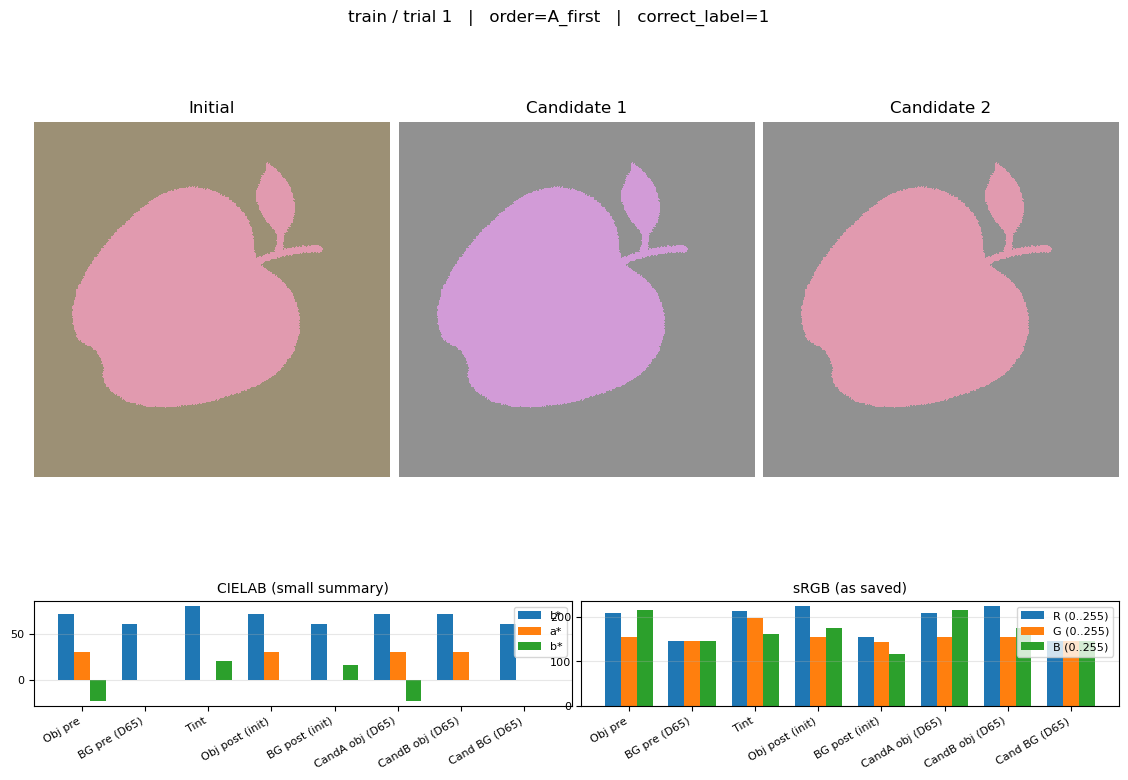

In [ ]:
browse_trials("train", 1)
